In [0]:
import numpy

In [0]:
9+9

18

In [0]:
import numpy as np
from keras import layers
from tensorflow.nn import avg_pool2d, max_pool2d
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
import numpy as np
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard
#from tensorflow.keras.applications import ResNet50
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
nvidia-smi

NameError: ignored

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11731444176629229250, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17739459270125400468
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 15288377143425628152
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 962395873400193119
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)


    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)


    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    
    return X

In [0]:
def ResNet50(input_shape = (224, 224, 3), classes = 2):
  
    X_input = Input(input_shape)

    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    #X = Dense(256, activation='relu')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [0]:
model=Sequential()
model.add(ResNet50(input_shape = (224, 224, 3), classes = 2))

In [0]:
import datetime, os

In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback =TensorBoard(logdir, histogram_freq=1)

In [0]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

In [0]:
model.summary()

In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
!unzip -uq "/content/drive/My Drive/DATASET" -d "/content/drive/My Drive/"

In [0]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
train= train_datagen.flow_from_directory('/content/drive/My Drive/cnn/DATASET/TRAIN',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test=train_datagen.flow_from_directory('/content/drive/My Drive/cnn/DATASET/TEST',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
X_train_orig,Y_train_orig=train.next()
X_test_orig,Y_test_orig=test.next()

Y_train_orig=Y_train_orig.astype(int)
Y_test_orig=Y_test_orig.astype(int)

#X_train_orig= keras.utils.to_categorical(X_train_orig, NB_CLASSES)
#X_test_orig = keras.utils.to_categorical(X_test_orig, NB_CLASSES)

Y_train = convert_to_one_hot(Y_train_orig, 2).T
Y_test = convert_to_one_hot(Y_test_orig, 2).T

print(X_train_orig.shape)
print(X_test_orig.shape)
print(Y_train.shape)
print(Y_test.shape)


(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 2)
(32, 2)


In [0]:
hist = model.fit_generator(train, epochs = 5, validation_data = test)

Epoch 1/5
 18/706 [..............................] - ETA: 2:43:40 - loss: 6.6520 - acc: 0.5625

KeyboardInterrupt: ignored

In [0]:
from tensorflow.keras.applications import ResNet50
res = ResNet50(input_shape = (224, 224, 3), include_top = True, weights = 'imagenet')
res.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a7b3fe01876f51b976af0dea6bc144eb so we will re-download the data.
102858752/102853048 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (C

In [0]:
import tensorflow as tf
model = tf.keras.models.Sequential()
model.add(res)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
model.summary()
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
hist = model.fit_generator(train, epochs = 5, validation_data = test)

Epoch 1/5
706/706 [==============================] - 7825s 11s/step - loss: 0.4299 - acc: 0.8203 - val_loss: 1.0907 - val_acc: 0.5730
Epoch 2/5
706/706 [==============================] - 592s 839ms/step - loss: 0.3366 - acc: 0.8623 - val_loss: 0.2795 - val_acc: 0.8993
Epoch 3/5
706/706 [==============================] - 589s 834ms/step - loss: 0.3127 - acc: 0.8770 - val_loss: 0.2410 - val_acc: 0.9053
Epoch 4/5
706/706 [==============================] - 592s 839ms/step - loss: 0.2875 - acc: 0.8872 - val_loss: 0.5501 - val_acc: 0.7788
Epoch 5/5
706/706 [==============================] - 595s 843ms/step - loss: 0.2664 - acc: 0.8966 - val_loss: 0.3417 - val_acc: 0.8615


In [0]:
model.save("waste_224.h5")

In [0]:
pwd


'/content'

In [0]:
cd 

/root


In [0]:
pwd

'/root'

In [0]:
cd '/content/sample_data'

/content/sample_data


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
import tensorflow.python.keras
model=load_model('/content/waste_224.h5')
/content/waste_224.h5

ValueError: ignored

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
hist = model.fit_generator(train, epochs = 15, validation_data = test)

Epoch 1/15
706/706 [==============================] - 592s 839ms/step - loss: 0.2676 - acc: 0.8969 - val_loss: 0.3925 - val_acc: 0.8571
Epoch 2/15
706/706 [==============================] - 601s 851ms/step - loss: 0.2592 - acc: 0.8996 - val_loss: 0.3657 - val_acc: 0.8329
Epoch 3/15
706/706 [==============================] - 606s 858ms/step - loss: 0.2417 - acc: 0.9075 - val_loss: 0.3243 - val_acc: 0.8802
Epoch 4/15
706/706 [==============================] - 593s 840ms/step - loss: 0.2365 - acc: 0.9078 - val_loss: 0.2576 - val_acc: 0.8977
Epoch 5/15
706/706 [==============================] - 593s 840ms/step - loss: 0.2329 - acc: 0.9107 - val_loss: 0.3885 - val_acc: 0.8265
Epoch 6/15
706/706 [==============================] - 594s 841ms/step - loss: 0.2107 - acc: 0.9189 - val_loss: 0.4075 - val_acc: 0.8516
Epoch 7/15
706/706 [==============================] - 596s 844ms/step - loss: 0.2120 - acc: 0.9175 - val_loss: 0.3458 - val_acc: 0.8587
Epoch 8/15
706/706 [============================

In [0]:
model.save("model_2242.h5")

In [0]:
model.evaluate(X_test_orig,Y_test_orig)

32/32 [==============================] - 0s 9ms/sample - loss: 0.4776 - acc: 0.8750


[0.47758740186691284, 0.875]

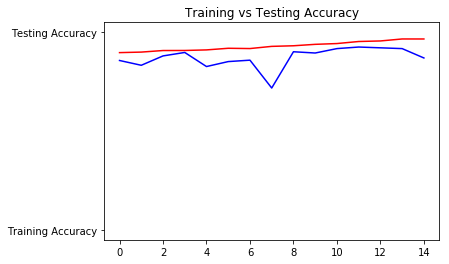

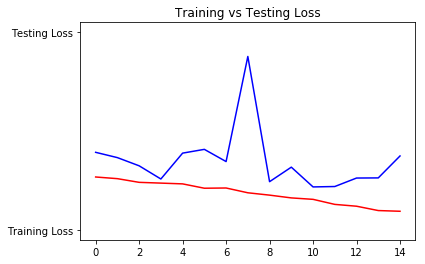

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Testing Accuracy")
plt.title('Training vs Testing Accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Testing Loss")
plt.title('Training vs Testing Loss')
plt.show()

In [0]:
import tensorflow as tf
import h5py
tf.keras.models.save_model(model,"/content/colab_model.h5")

In [0]:
new_model=tf.keras.models.load_model(
    "/content/colab_model.h5",
    custom_objects=None,
    compile=True
)

In [0]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 25,893,482
Trainable params: 25,840,362
Non-trainable params: 53,120
_________________________________________________________________


In [1]:
from PIL import Image
image = Image.open('veg.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
#size = 224, 224
#image.thumbnail(size, Image.ANTIALIAS)


JPEG
RGB
(1000, 667)


In [0]:
cd ;

/


(224, 224, 3)
RGB


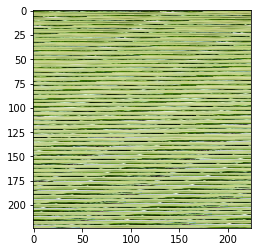

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
img_array=tf.keras.preprocessing.image.img_to_array(image)
# print(img_array)
#print(img_array)
img_array=img_array/255.
#print(img_array)
img_array.resize([224,224,3])
print(img_array.shape)
img2=tf.keras.preprocessing.image.array_to_img(img_array)
plt.imshow(img_array)
print(img2.mode)

In [0]:
inputt=[]
inputt.append([img_array])
new_model.predict(inputt)

AttributeError: ignored

In [0]:
from PIL import Image